# Flappy Bird

In [14]:
# @ title Imports
from time import sleep
from typing import Tuple, Literal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import clear_output
from deep_rl.environments.flappy_bird import FlappyBird
from deep_rl.shapes import Point, Rectangle
from deep_rl.terminal_renderer import BashRenderer

from src import (
    infer_parameters,
    TreeBuilder,
    get_best_action,
    print_outcomes_stats,
    repr_obs,
    repr_bars,
    print_successful_decisions,
    print_successful_trajectories,
)

In [2]:
params = {"gravity": 0.05, "force_push": 0.1, "vx": 0.05}
env = FlappyBird(**params, prob_new_bar=1, max_height_bar=0.5)

In [3]:
# @ title Inferring the parameters
gravity, force_push, vx = infer_parameters(env)
assert np.allclose(
    [gravity, force_push, vx],
    (
        params["gravity"],
        params["force_push"],
        params["vx"],
    ),
    rtol=1e-3,
), "Parameters inference failed"

In [4]:
# @title Building the tree
env.reset()
(bird_x, bird_y, bird_vy), bars = env.step(0)[0]
tree = TreeBuilder(bars, gravity, force_push, vx)
outcomes = tree.build_tree(bird_x, bird_y, bird_vy)
print(
    f"\nNumber of leaves computed: {tree.n_steps_computed}\n"
    f"Number of leave computation steps saved: {tree.n_steps_saved}\n"
)
print_outcomes_stats(outcomes)


Number of leaves computed: 620
Number of leave computation steps saved: 1428


Number of favorable outcomes:    553 / 2048  (27.00%)
- Probability of winning when standing still: 8.84%
- Probability of winning when jumping:        18.16%



## Experiments

In [5]:
def launch_experiment(
    environment: FlappyBird,
    rendering_size: Tuple[int, int] = (20, 40),
    time_between_frames: float = 0.1,
    clear_between_frames: bool = False,
    max_steps: int = 1000,
    print_additional_info: Literal["decisions", "trajectories"] | None = None,
) -> Tuple[int, int]:
    step, total_reward = 0, 0
    renderer = BashRenderer(*rendering_size, clear_fn=lambda: clear_output(wait=True))

    observation = environment.reset()
    for step in range(1, max_steps + 1):
        # rebuilding the tree from scratch each time
        tree_builder = TreeBuilder(
            observation[1], gravity, force_push, vx, max_bars=100
        )
        predicted_outcomes = tree_builder.build_tree(*observation[0])
        assert (
            tree_builder.n_steps_computed + tree_builder.n_steps_saved
            == predicted_outcomes.shape[0]
        ), "Not all outcomes were the product of a proper computation"

        # printing some useful information
        print_outcomes_stats(predicted_outcomes)
        if print_additional_info == "decisions":
            print_successful_decisions(predicted_outcomes, max_lines=0)
        elif print_additional_info == "trajectories":
            print_successful_trajectories(
                observation[0][0],
                observation[0][1],
                observation[0][2],
                gravity,
                force_push,
                vx,
                predicted_outcomes,
            )

        # playing
        action = get_best_action(predicted_outcomes)
        observation, reward, done = environment.step(action)
        print(
            f"\naction: {action}, reward: {reward}, observation: {repr_obs(observation)}"
        )
        # checking if the tree sees the same bars
        if step > 1:
            print("\nBars the TreeBuilder sees:")
            print(repr_bars(tree_builder.bars))

        total_reward += reward
        print(f"\nCumulated reward at step {step}: {total_reward:>3}.")
        if done:
            print(f"Simulation ended after {step} steps.")
            break

        # rendering the environment
        if clear_between_frames:
            renderer.clear()
        renderer.draw_list(environment.render())
        renderer.draw_title(f"Total reward : {total_reward}")
        renderer.render()
        sleep(time_between_frames)

        background = Rectangle(
            bot_left=Point(x=0, y=0),
            top_right=Point(x=1, y=1),
        )

    return total_reward, step

In [15]:
def launch_experiment_without_rendering(
    environment: FlappyBird,
    max_steps: int = 10000,
    verbose: bool = False,
) -> Tuple[int, int]:
    step, total_reward = 0, 0

    observation = environment.reset()
    for step in range(1, max_steps + 1):
        # rebuilding the tree from scratch each time
        tree_builder = TreeBuilder(
            observation[1], gravity, force_push, vx, max_bars=100000
        )
        predicted_outcomes = tree_builder.build_tree(*observation[0])

        # playing
        action = get_best_action(predicted_outcomes)
        observation, reward, done = environment.step(action)
        if verbose:
            print(
                f"\naction: {action}, reward: {reward}, observation: {repr_obs(observation)}"
            )

        total_reward += reward
        if verbose:
            print(f"\nCumulated reward at step {step}: {total_reward:>3}.")
        if done:
            if verbose:
                print(f"Simulation ended after {step} steps.")
            break

    return total_reward, step

In [8]:
launch_experiment(env)


Number of favorable outcomes:    376 / 1024  (36.72%)
- Probability of winning when standing still: 18.16%
- Probability of winning when jumping:        18.55%


action: 1, reward: 0, observation: (0.50, 0.55, 0.05)
 - (1.00, 1.10, 0.45, BOTTOM)

Cumulated reward at step 1:   0.
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　🐤　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　

(193, 553)



Reward over 1000 experiments: 57.30 +/- 116.69
Number of steps: 180.08 +/- 333.04


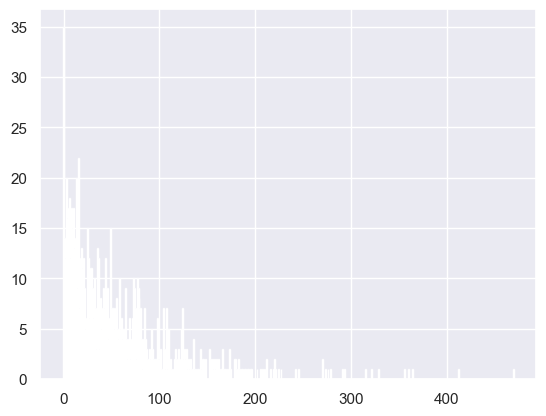

CPU times: user 4min 39s, sys: 1.55 s, total: 4min 40s
Wall time: 4min 41s


In [18]:
%%time
n_experiments = 1000  # @param {type:"slider", min:50, max:1000, step:10}

rewards = np.zeros(n_experiments)
n_steps = np.zeros(n_experiments)

for i in range(n_experiments):
    rewards[i], n_steps[i] = launch_experiment_without_rendering(env)
print(
    f"\n\nReward over {n_experiments} experiments: {rewards.mean():.2f} +/- {1.96 * rewards.std():.2f}"
)
print(f"Number of steps: {n_steps.mean():.2f} +/- {1.96 * n_steps.std():.2f}")

sns.set_theme()
plt.figure(figsize=(14, 14))
plt.hist(rewards, bins=int(rewards.max()))
plt.show()